# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc,roc_auc_score

import warnings
warnings.simplefilter("ignore")

In [84]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0                      0             5.52   
1                     0                      0             5.52   
2                     1                      0             5.52   
3                     0                      1             5.52   
4                     0                      1             5.52   

   booking_complete  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [120]:
df[df.duplicated()]['booking_complete'].value_counts()

booking_complete
0    632
1     87
Name: count, dtype: int64

In [85]:
df.drop_duplicates(inplace=True)

In [116]:
df[df['trip_type'] == 'CircleTrip']

num_passengers sales_channel   trip_type  purchase_lead  \
20                  2      Internet  CircleTrip            228   
78                  1        Mobile  CircleTrip            281   
79                  1      Internet  CircleTrip            282   
4604                1      Internet  CircleTrip            157   
4720                1      Internet  CircleTrip             48   
...               ...           ...         ...            ...   
48844               1      Internet  CircleTrip              0   
49036               1      Internet  CircleTrip             40   
49045               1      Internet  CircleTrip            116   
49073               1      Internet  CircleTrip            303   
49317               1      Internet  CircleTrip             27   

       length_of_stay  flight_hour  flight_day   route booking_origin  \
20                 29           23           3  AKLHND    New Zealand   
78                 18            3           3  AKLKTM    New Zealand   
79                 18           19           2  AKLKTM    New Zealand   
4604               19           11           7  CMBKIX          Japan   
4720               18            9           7  CMBMEL      Australia   
...               ...          ...         ...     ...            ...   
48844               6            9           7  MELPEN      Australia   
49036               6            8           4  MELTPE      Australia   
49045               6           12           6  MELTPE      Australia   
49073               6           12           2  MELTPE      Australia   
49317               6           11           2  OOLPUS    New Zealand   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
20                       1                     0                      0   
78                       1                     0                      0   
79                       1                     0                      0   
4604                     1                     1                      1   
4720                     1                     0                      0   
...                    ...                   ...                    ...   
48844                    1                     0                      0   
49036                    1                     1                      0   
49045                    1                     0                      0   
49073                    0                     0                      0   
49317                    1                     0                      1   

       flight_duration  booking_complete  
20                7.57                 0  
78                4.75                 0  
79                4.75                 0  
4604              7.00                 0  
4720              8.83                 0  
...                ...               ...  
48844             8.83                 0  
49036             8.83                 0  
49045             8.83                 0  
49073             8.83                 0  
49317             8.83                 0  

[116 rows x 14 columns]

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion


features:
- num passenger bigger than 1 
- purchase lead - 0-3 days, 3-10 days, 10-30 days, 30-90, 90-180, 180-365, 365>
- length_of_stay - 0-3 days, 3-7 days, 7-10 days, 10-14 days, 14-30 days, 30-90, 90-180, 180-365, 365>
- flight hour - morning 5-9, late morning 9-13, 13-17, 17-23, 23-5
- flight day - workday 1-4 & 5 till 17, weekend 5 after 17 & 6-7
- route : origin and destination ( find all iarports abbr in the internet)
- origin the sane as booking origin 
- flight_duration : short 1-3 , middle 3-6, long 6+
- any extra 
- booking origin - Europe, Australia, Africa, North America, South America, Asia

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [86]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [7]:
df.describe()

num_passengers  purchase_lead  length_of_stay  flight_hour  \
count    50000.000000   50000.000000     50000.00000  50000.00000   
mean         1.591240      84.940480        23.04456      9.06634   
std          1.020165      90.451378        33.88767      5.41266   
min          1.000000       0.000000         0.00000      0.00000   
25%          1.000000      21.000000         5.00000      5.00000   
50%          1.000000      51.000000        17.00000      9.00000   
75%          2.000000     115.000000        28.00000     13.00000   
max          9.000000     867.000000       778.00000     23.00000   

         flight_day  wants_extra_baggage  wants_preferred_seat  \
count  50000.000000         50000.000000          50000.000000   
mean       3.814420             0.668780              0.296960   
std        1.992792             0.470657              0.456923   
min        1.000000             0.000000              0.000000   
25%        2.000000             0.000000              0.000000   
50%        4.000000             1.000000              0.000000   
75%        5.000000             1.000000              1.000000   
max        7.000000             1.000000              1.000000   

       wants_in_flight_meals  flight_duration  booking_complete  
count           50000.000000     50000.000000      50000.000000  
mean                0.427140         7.277561          0.149560  
std                 0.494668         1.496863          0.356643  
min                 0.000000         4.670000          0.000000  
25%                 0.000000         5.620000          0.000000  
50%                 0.000000         7.570000          0.000000  
75%                 1.000000         8.830000          0.000000  
max                 1.000000         9.500000          1.000000

The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [7]:
cat_cols = df.select_dtypes('object').columns.tolist()
num_cols = [col for col in df.columns if col not in cat_cols]

## Categorical analysis 

In [14]:
df[cat_cols]

sales_channel  trip_type   route booking_origin
0          Internet  RoundTrip  AKLDEL    New Zealand
1          Internet  RoundTrip  AKLDEL    New Zealand
2          Internet  RoundTrip  AKLDEL          India
3          Internet  RoundTrip  AKLDEL    New Zealand
4          Internet  RoundTrip  AKLDEL          India
...             ...        ...     ...            ...
49995      Internet  RoundTrip  PERPNH      Australia
49996      Internet  RoundTrip  PERPNH      Australia
49997      Internet  RoundTrip  PERPNH      Australia
49998      Internet  RoundTrip  PERPNH      Australia
49999      Internet  RoundTrip  PERPNH      Australia

[50000 rows x 4 columns]

In [23]:
df['route'].nunique()

799

In [24]:
df['booking_origin'].nunique()

104

In [113]:
for col in cat_cols:
    print(df[col].value_counts())

sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64
trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64
route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64
booking_origin
Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64


In [52]:
df[(df['trip_type'] == 'OneWay') & (df['length_of_stay'] > 1)] 

num_passengers sales_channel trip_type  purchase_lead  length_of_stay  \
355                 5      Internet    OneWay            198              34   
1195                1      Internet    OneWay             66              26   
2463                1      Internet    OneWay            236              21   
3886                4        Mobile    OneWay              6              24   
4121                2      Internet    OneWay              7              32   
...               ...           ...       ...            ...             ...   
48824               2      Internet    OneWay             40               6   
48921               2      Internet    OneWay            184               6   
48922               1      Internet    OneWay            186               6   
48928               2      Internet    OneWay            294               6   
49479               2      Internet    OneWay             42               6   

       flight_hour  flight_day   route booking_origin  wants_extra_baggage  \
355             14           1  AKLKUL      Hong Kong                    1   
1195             6           4  AKLKUL        Vietnam                    0   
2463            11           3  BKIMEL       Malaysia                    0   
3886             4           3  CGKICN      Indonesia                    1   
4121             7           2  CGKMEL      Australia                    1   
...            ...         ...     ...            ...                  ...   
48824            5           1  MELPEK          China                    1   
48921            7           6  MELPUS    South Korea                    0   
48922            8           3  MELPUS    South Korea                    1   
48928            7           3  MELPVG       Malaysia                    1   
49479            5           2  PEKSUB          China                    1   

       wants_preferred_seat  wants_in_flight_meals  flight_duration  \
355                       1                      1             8.83   
1195                      0                      1             8.83   
2463                      1                      1             8.83   
3886                      1                      1             6.62   
4121                      0                      0             8.83   
...                     ...                    ...              ...   
48824                     0                      1             8.83   
48921                     0                      0             8.83   
48922                     0                      0             8.83   
48928                     1                      0             8.83   
49479                     0                      1             6.42   

       booking_complete  
355                   0  
1195                  0  
2463                  0  
3886                  1  
4121                  0  
...                 ...  
48824                 0  
48921                 0  
48922                 0  
48928                 0  
49479                 0  

[319 rows x 14 columns]

## Numerical analysis

In [26]:
df[num_cols]

num_passengers  purchase_lead  length_of_stay  flight_hour  flight_day  \
0                   2            262              19            7           6   
1                   1            112              20            3           6   
2                   2            243              22           17           3   
3                   1             96              31            4           6   
4                   2             68              22           15           3   
...               ...            ...             ...          ...         ...   
49995               2             27               6            9           6   
49996               1            111               6            4           7   
49997               1             24               6           22           6   
49998               1             15               6           11           1   
49999               1             19               6           10           4   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
0                        1                     0                      0   
1                        0                     0                      0   
2                        1                     1                      0   
3                        0                     0                      1   
4                        1                     0                      1   
...                    ...                   ...                    ...   
49995                    1                     0                      1   
49996                    0                     0                      0   
49997                    0                     0                      1   
49998                    1                     0                      1   
49999                    0                     1                      0   

       flight_duration  booking_complete  
0                 5.52                 0  
1                 5.52                 0  
2                 5.52                 0  
3                 5.52                 0  
4                 5.52                 0  
...                ...               ...  
49995             5.62                 0  
49996             5.62                 0  
49997             5.62                 0  
49998             5.62                 0  
49999             5.62                 0  

[50000 rows x 10 columns]

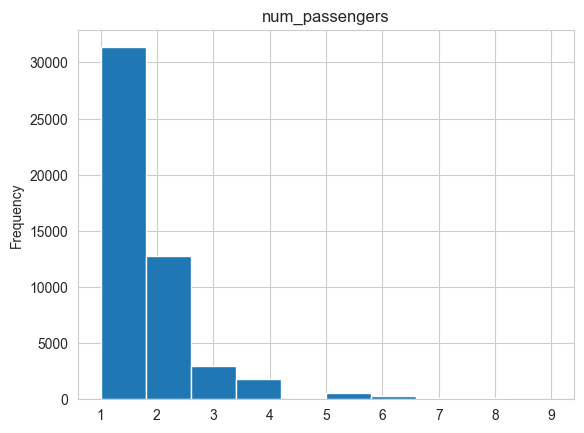

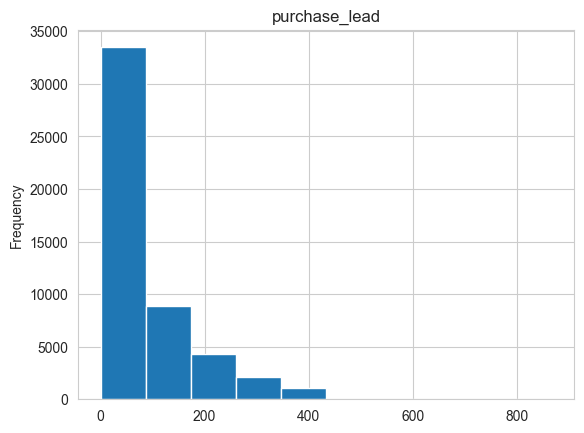

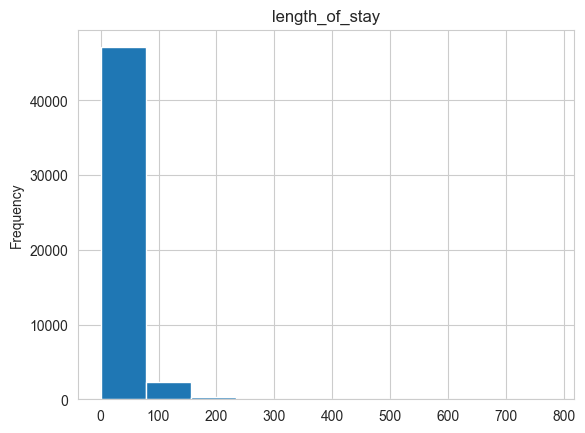

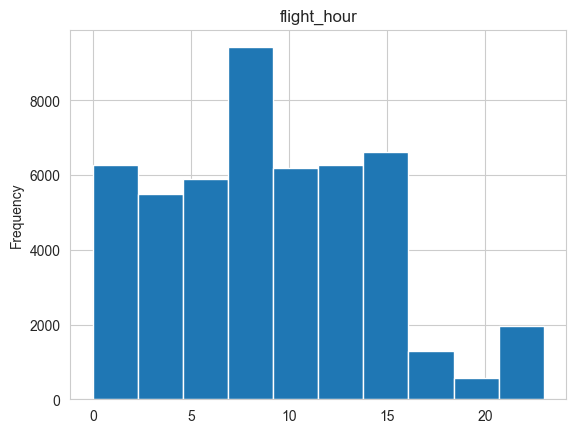

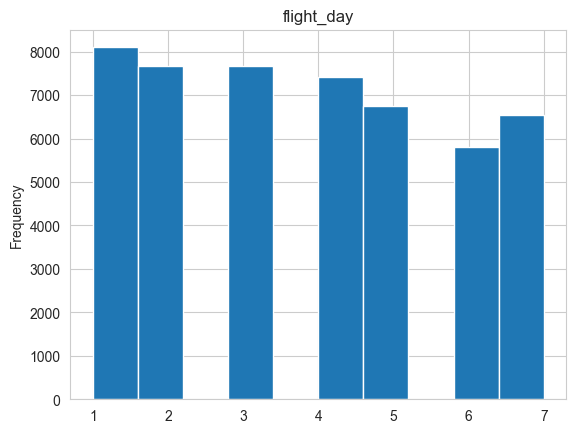

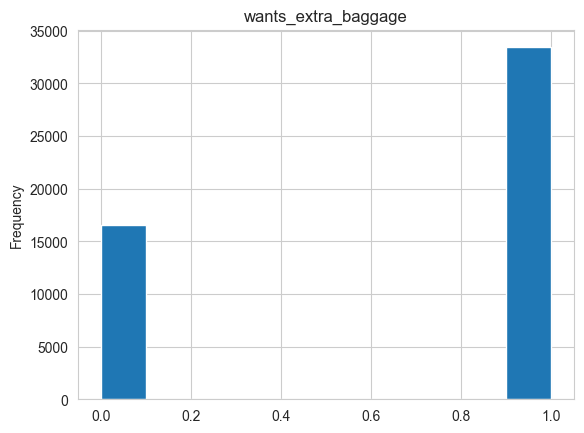

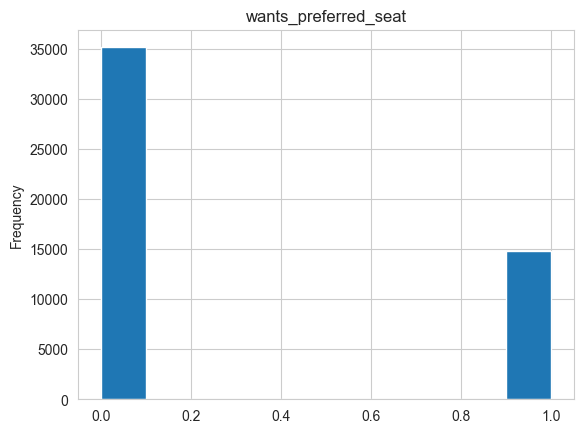

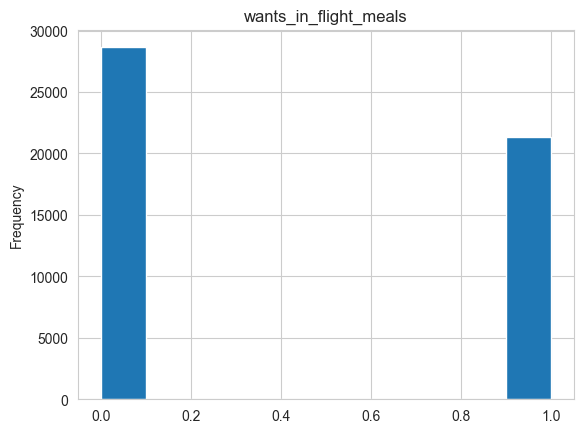

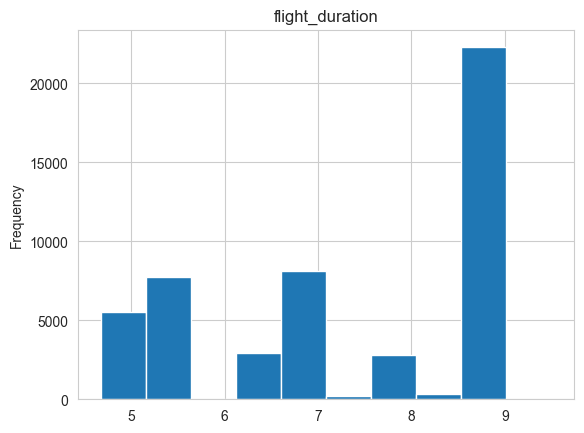

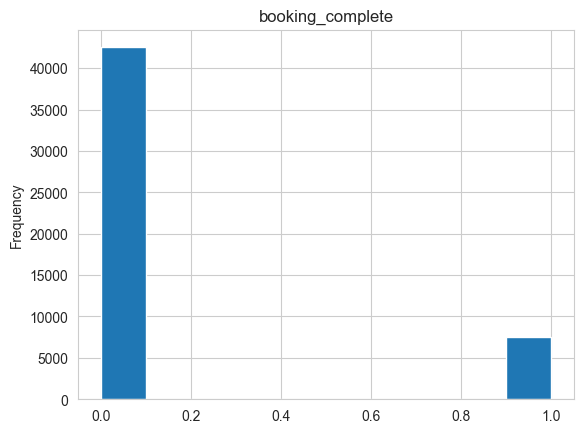

In [28]:
for col in num_cols:
    df[col].plot(kind='hist')
    plt.title(col)
    plt.show()

In [35]:
for col in num_cols:
    print(df[df[col] < 0].shape)

(0, 14)
(0, 14)
(0, 14)
(0, 14)
(0, 14)
(0, 14)
(0, 14)
(0, 14)
(0, 14)
(0, 14)


In [36]:
df[df['purchase_lead'] > 365].shape

(838, 14)

In [40]:
df[df['purchase_lead'] > 365]['booking_complete'].value_counts()

booking_complete
0    722
1    116
Name: count, dtype: int64

In [46]:
df[(df['purchase_lead'] >365 )].shape

(838, 14)

In [50]:
df[df['length_of_stay'] > 365].shape

(23, 14)

In [ ]:
df['']

In [32]:
df['booking_complete'].value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

## Multivariate Analysis

In [55]:
corr = df[num_cols].corr()

<Axes: >

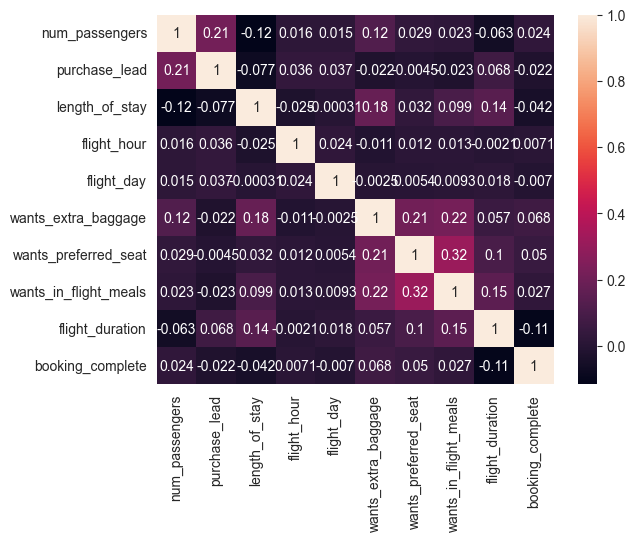

In [57]:
sns.heatmap(corr, annot=True)

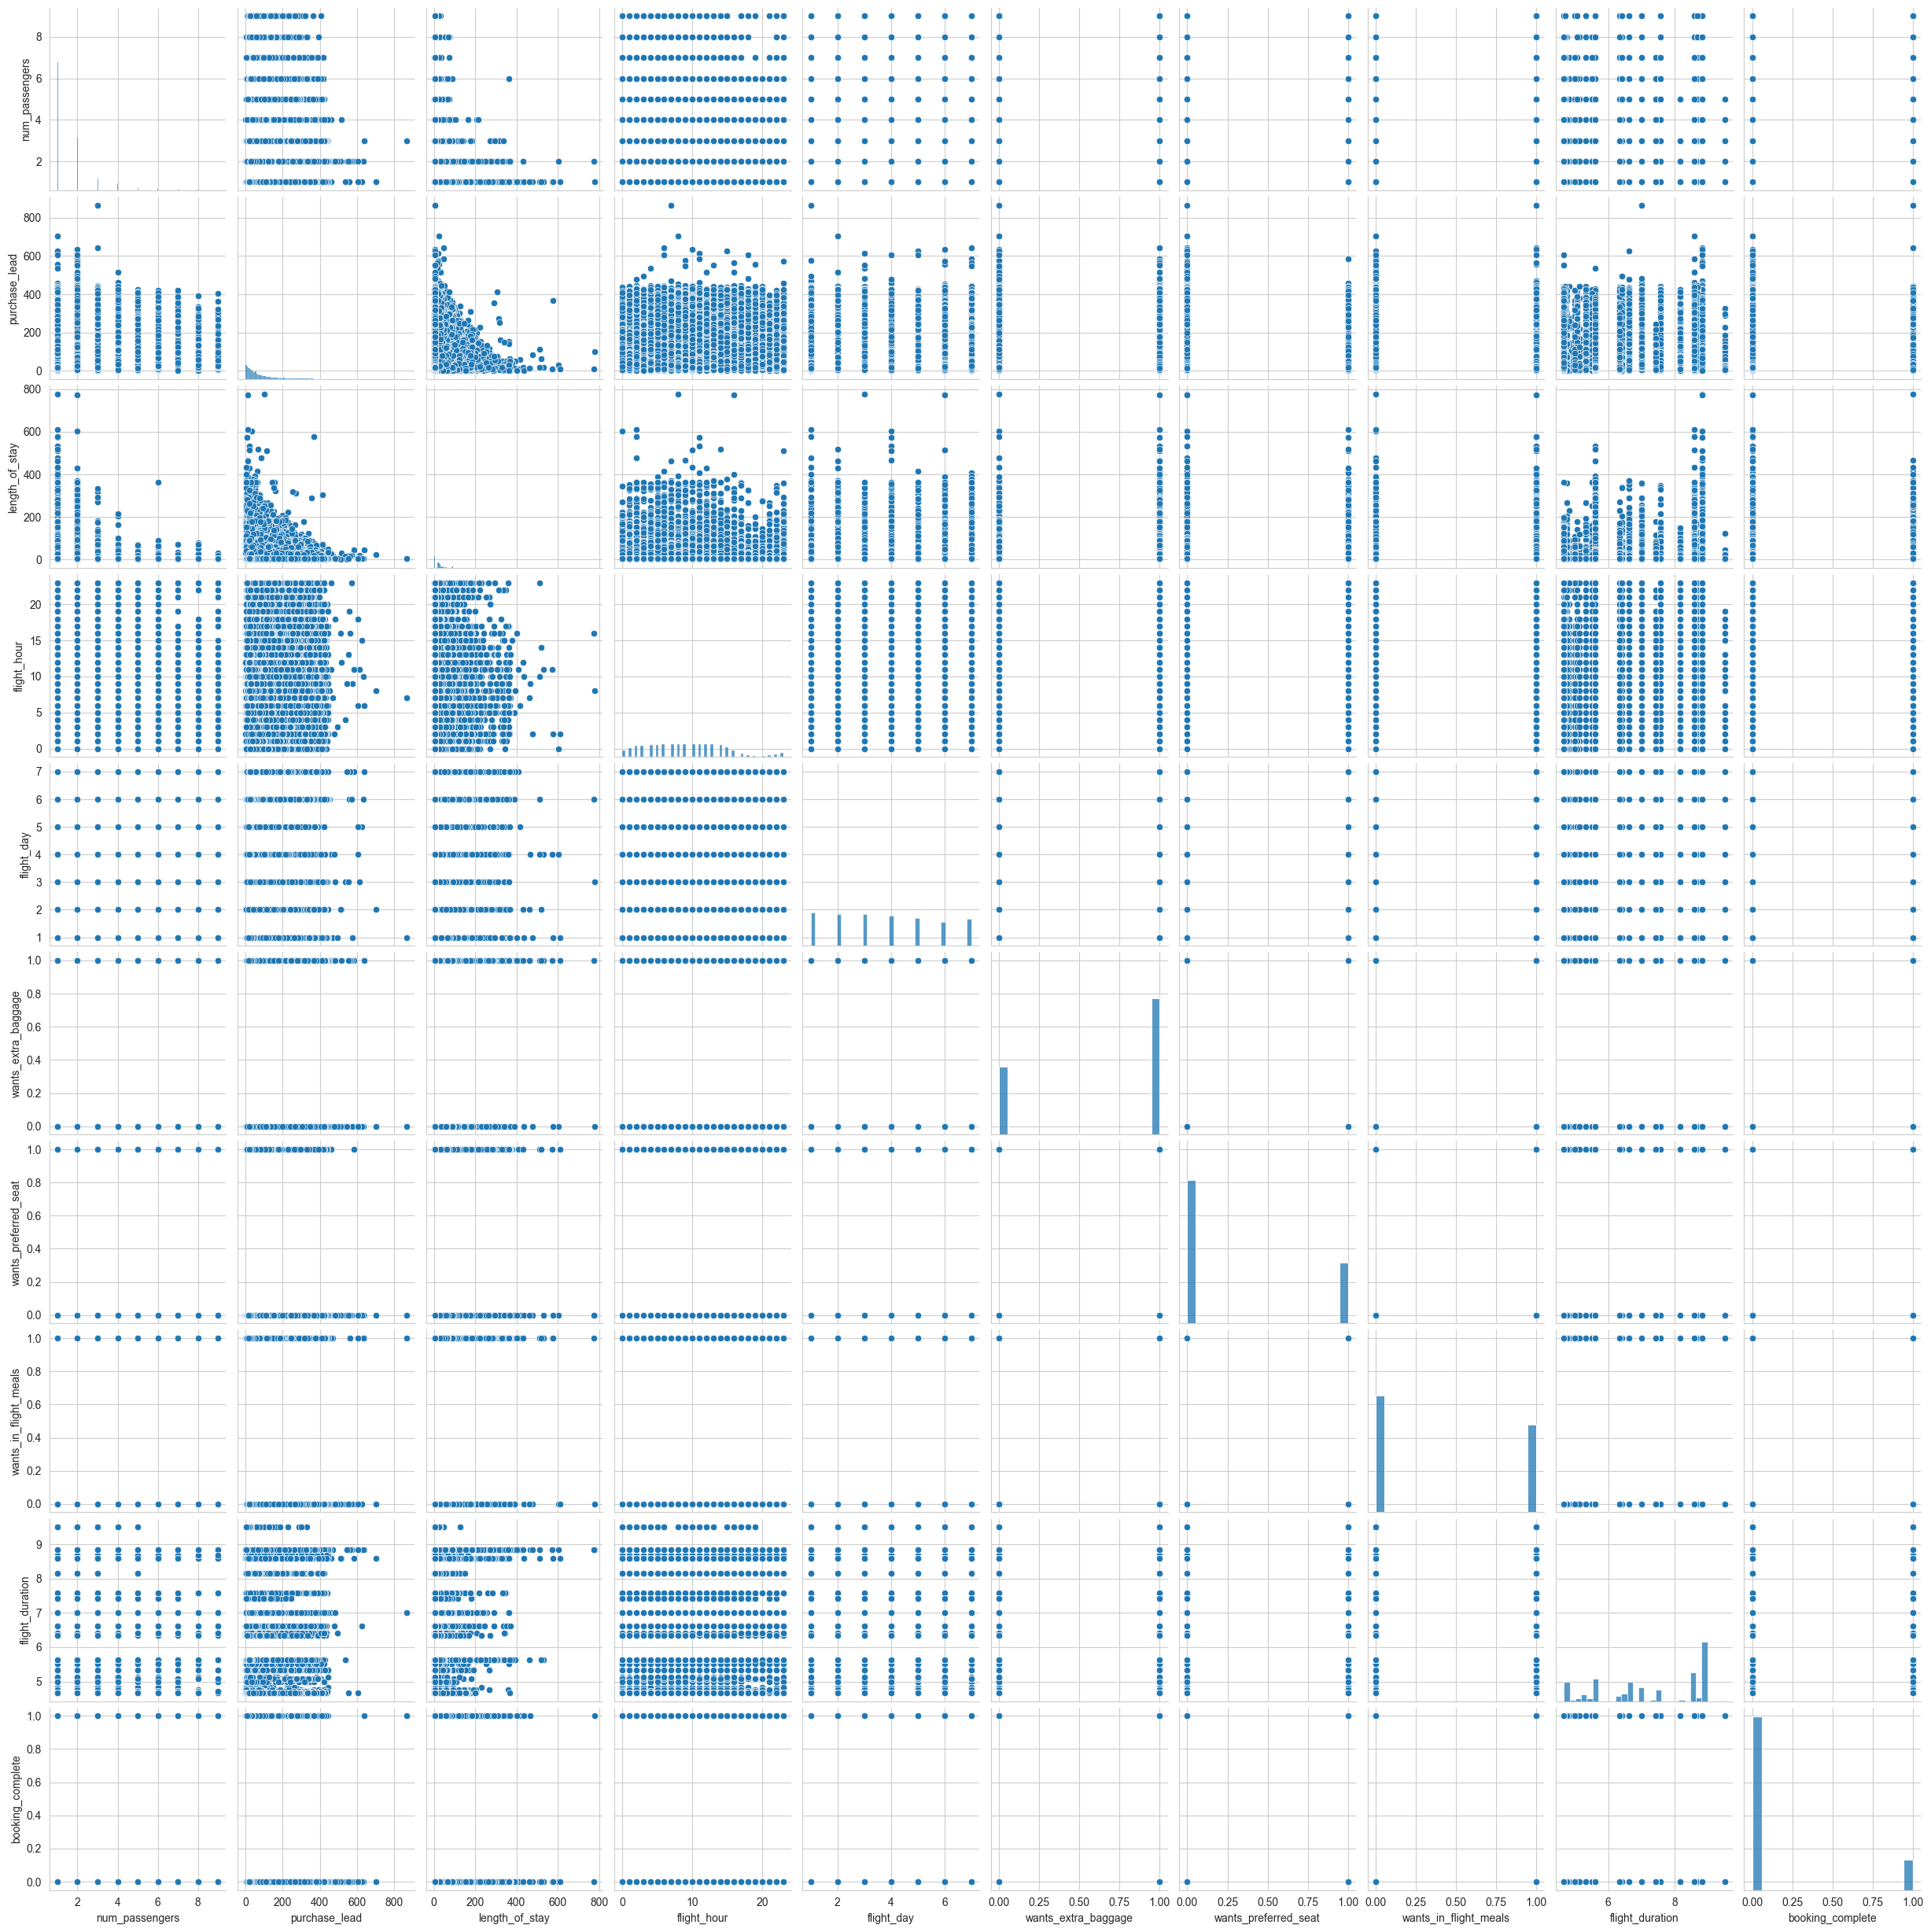

In [58]:
sns.pairplot(df)

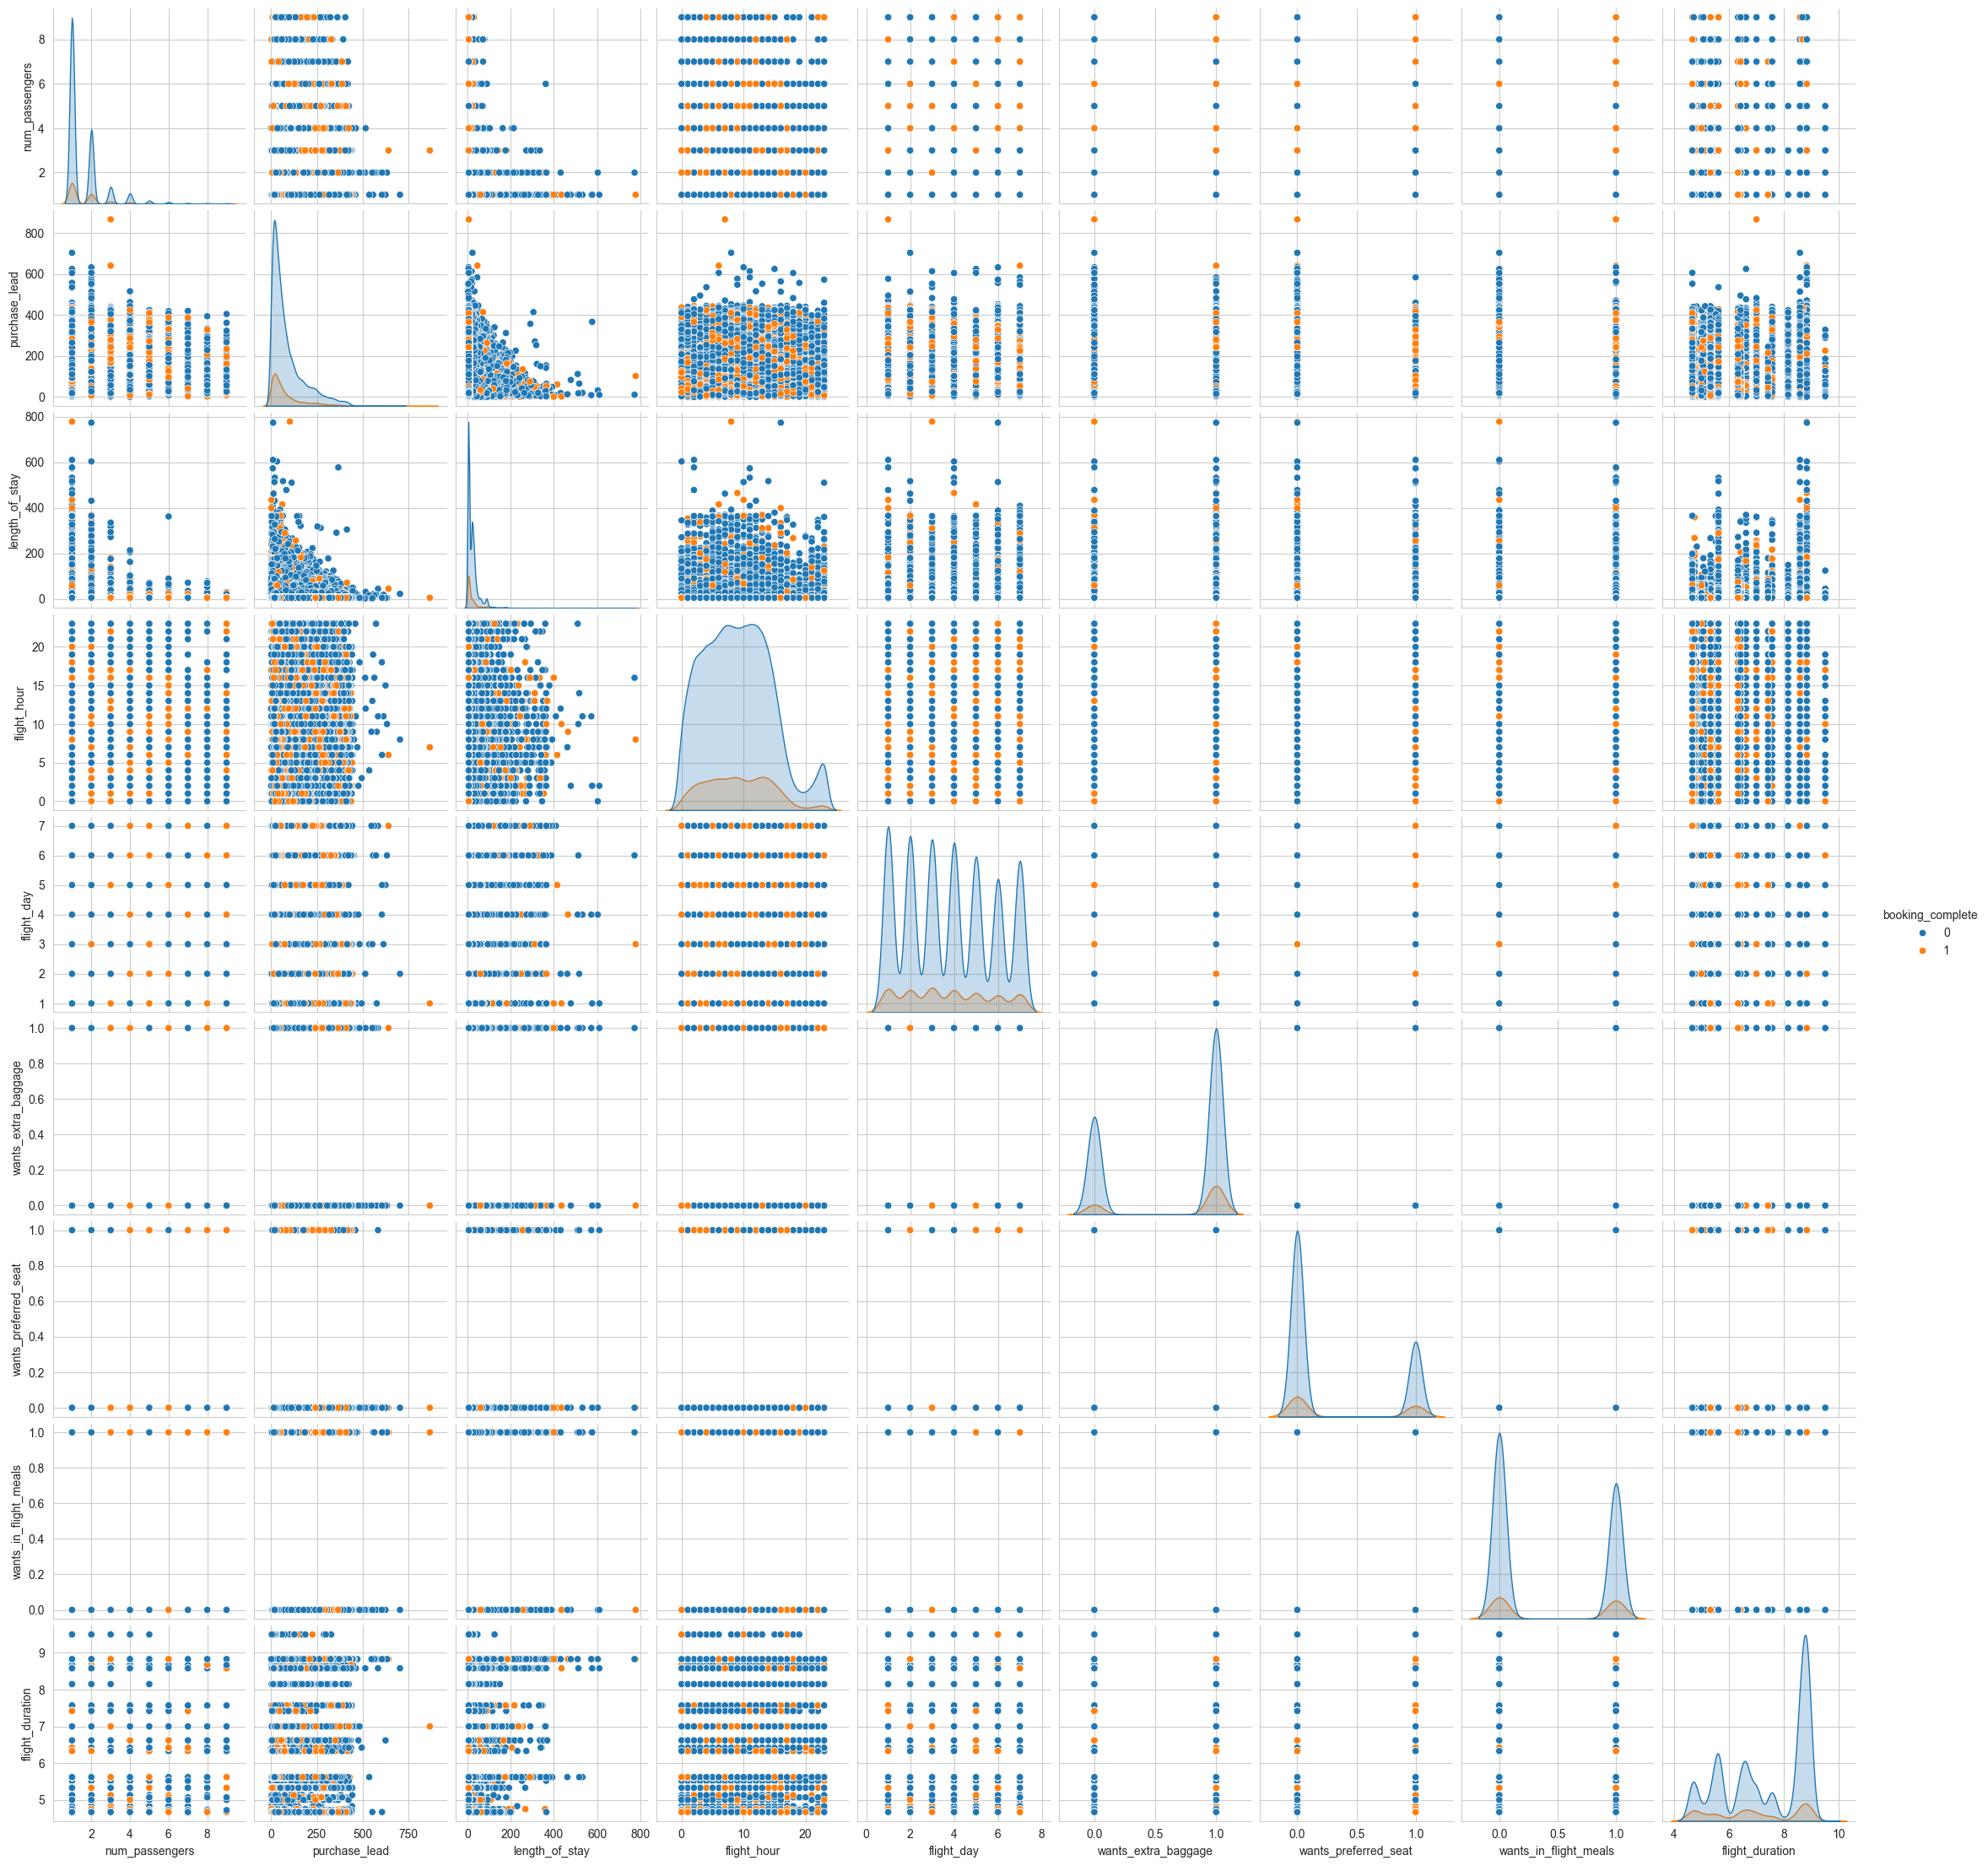

In [87]:
sns.pairplot(df[num_cols], hue='booking_complete')

# Feature engineering 

In [87]:
# 1. Number of passengers greater than 1
df['multiple_passengers'] = (df['num_passengers'] > 1).astype(int)

# 2. Purchase lead buckets
bins = [0, 7, 21, 60, 180, 365, df['purchase_lead'].max()+1]
# labels = ['0-7 days', '7-21 days', '21-60 days', '60-180 days', '180-365 days', '365+ days']
labels = [1, 2, 3, 4, 5, 6]

df['purchase_lead_bucket'] = pd.cut(df['purchase_lead'], bins=bins, labels=labels, right=False)

# 3. Length of stay buckets
stay_bins = [0, 7, 21, 60, 90, 180, df['length_of_stay'].max()+1]
# stay_labels = ['0-7 days', '7-21 days', '21-60 days', '60-90 days', '90-180 days', '180+']
stay_labels = [1, 2, 3, 4, 5, 6]

df['stay_length_bucket'] = pd.cut(df['length_of_stay'], bins=stay_bins, labels=stay_labels, right=False)

# 4. Flight hour categories
# def map_flight_hour(hour):
#     if 5 <= hour < 9:
#         return 'morning'
#     elif 9 <= hour < 13:
#         return 'late morning'
#     elif 13 <= hour < 17:
#         return 'afternoon'
#     elif 17 <= hour < 23:
#         return 'evening'
#     else:
#         return 'night'
    
def map_flight_hour(hour):
    if 5 <= hour < 9:
        return 1
    elif 9 <= hour < 13:
        return 2
    elif 13 <= hour < 17:
        return 3
    elif 17 <= hour < 23:
        return 4
    else:
        return 5

df['flight_hour_bucket'] = df['flight_hour'].apply(map_flight_hour)

# 5. Flight day: workday/weekend
# def classify_flight_day(day, hour):
#     if (1 <= day <= 4) or (day == 5 and hour < 17):
#         return 'workday'
#     else:
#         return 'weekend'
    
def classify_flight_day(day, hour):
    if (1 <= day <= 5):
        return 0
    else:
        return 1

df['flight_day_type'] = df.apply(lambda x: classify_flight_day(x['flight_day'], x['flight_hour']), axis=1)

# 8. Flight duration categories
# df['flight_duration_category'] = pd.cut(df['flight_duration'], bins=[0, 6, df['flight_duration'].max()+1], labels=['middle', 'long'], right=False)
df['flight_duration_category'] = pd.cut(df['flight_duration'], bins=[0, 6, df['flight_duration'].max()+1], labels=[0, 1], right=False)


# 9. Any extras selected
df['any_extras'] = df[['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']].sum(axis=1).astype(bool).astype(int)

df['all_extras'] = (df['wants_extra_baggage'] & df['wants_preferred_seat'] & df['wants_in_flight_meals']).astype(int)


In [154]:
|df

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49995               2      Internet  RoundTrip             27               6   
49996               1      Internet  RoundTrip            111               6   
49997               1      Internet  RoundTrip             24               6   
49998               1      Internet  RoundTrip             15               6   
49999               1      Internet  RoundTrip             19               6   

       flight_hour  flight_day   route booking_origin  wants_extra_baggage  \
0                7           6  AKLDEL    New Zealand                    1   
1                3           6  AKLDEL    New Zealand                    0   
2               17           3  AKLDEL          India                    1   
3                4           6  AKLDEL    New Zealand                    0   
4               15           3  AKLDEL          India                    1   
...            ...         ...     ...            ...                  ...   
49995            9           6  PERPNH      Australia                    1   
49996            4           7  PERPNH      Australia                    0   
49997           22           6  PERPNH      Australia                    0   
49998           11           1  PERPNH      Australia                    1   
49999           10           4  PERPNH      Australia                    0   

       ...  wants_in_flight_meals  flight_duration  booking_complete  \
0      ...                      0             5.52                 0   
1      ...                      0             5.52                 0   
2      ...                      0             5.52                 0   
3      ...                      1             5.52                 0   
4      ...                      1             5.52                 0   
...    ...                    ...              ...               ...   
49995  ...                      1             5.62                 0   
49996  ...                      0             5.62                 0   
49997  ...                      1             5.62                 0   
49998  ...                      1             5.62                 0   
49999  ...                      0             5.62                 0   

       multiple_passengers  purchase_lead_bucket stay_length_bucket  \
0                        1          180-365 days          7-21 days   
1                        0           60-180 days          7-21 days   
2                        1          180-365 days         21-60 days   
3                        0           60-180 days         21-60 days   
4                        1           60-180 days         21-60 days   
...                    ...                   ...                ...   
49995                    1            21-60 days           0-7 days   
49996                    0           60-180 days           0-7 days   
49997                    0            21-60 days           0-7 days   
49998                    0             7-21 days           0-7 days   
49999                    0             7-21 days           0-7 days   

      flight_time_of_day flight_day_type flight_duration_category any_extras  
0                morning         weekend                   middle          1  
1                  night         weekend                   middle          0  
2                evening         workday                   middle          1  
3                  night         weekend                   midd

In [150]:
new_cols = ['purchase_lead_bucket', 'stay_length_bucket', 'flight_time_of_day', 'flight_day_type', 'flight_duration_category']

In [151]:
for col in new_cols:
    print(df[col].value_counts())

purchase_lead_bucket
21-60 days      15139
60-180 days     14919
7-21 days        7932
180-365 days     6316
0-7 days         4140
365+ days         834
Name: count, dtype: int64
stay_length_bucket
0-7 days       24251
21-60 days     15177
7-21 days       5676
60-90 days      2504
90-180 days     1291
180+             381
Name: count, dtype: int64
flight_time_of_day
night           12545
late morning    12332
morning         12032
afternoon        9566
evening          2806
Name: count, dtype: int64
flight_day_type
workday    36627
weekend    12654
Name: count, dtype: int64
flight_duration_category
long      36181
middle    13064
Name: count, dtype: int64


In [148]:
df["booking_complete"].dtype

dtype('int64')

In [161]:
for col in new_cols:
    print(df.groupby(['booking_complete', col]).size())

booking_complete  purchase_lead_bucket
0                 0-7 days                 3434
                  7-21 days                6551
                  21-60 days              12872
                  60-180 days             12901
                  180-365 days             5413
                  365+ days                 719
1                 0-7 days                  706
                  7-21 days                1381
                  21-60 days               2267
                  60-180 days              2018
                  180-365 days              903
                  365+ days                 115
dtype: int64
booking_complete  stay_length_bucket
0                 0-7 days              19582
                  7-21 days              5083
                  21-60 days            13661
                  60-90 days             2107
                  90-180 days            1139
                  180+                    318
1                 0-7 days               4669
             

In [159]:
df

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49995               2      Internet  RoundTrip             27               6   
49996               1      Internet  RoundTrip            111               6   
49997               1      Internet  RoundTrip             24               6   
49998               1      Internet  RoundTrip             15               6   
49999               1      Internet  RoundTrip             19               6   

       flight_hour  flight_day   route booking_origin  wants_extra_baggage  \
0                7           6  AKLDEL    New Zealand                    1   
1                3           6  AKLDEL    New Zealand                    0   
2               17           3  AKLDEL          India                    1   
3                4           6  AKLDEL    New Zealand                    0   
4               15           3  AKLDEL          India                    1   
...            ...         ...     ...            ...                  ...   
49995            9           6  PERPNH      Australia                    1   
49996            4           7  PERPNH      Australia                    0   
49997           22           6  PERPNH      Australia                    0   
49998           11           1  PERPNH      Australia                    1   
49999           10           4  PERPNH      Australia                    0   

       ...  booking_complete  multiple_passengers  purchase_lead_bucket  \
0      ...                 0                    1          180-365 days   
1      ...                 0                    0           60-180 days   
2      ...                 0                    1          180-365 days   
3      ...                 0                    0           60-180 days   
4      ...                 0                    1           60-180 days   
...    ...               ...                  ...                   ...   
49995  ...                 0                    1            21-60 days   
49996  ...                 0                    0           60-180 days   
49997  ...                 0                    0            21-60 days   
49998  ...                 0                    0             7-21 days   
49999  ...                 0                    0             7-21 days   

       stay_length_bucket  flight_time_of_day flight_day_type  \
0               7-21 days             morning         weekend   
1               7-21 days               night         weekend   
2              21-60 days             evening         workday   
3              21-60 days               night         weekend   
4              21-60 days           afternoon         workday   
...                   ...                 ...             ...   
49995            0-7 days        late morning         weekend   
49996            0-7 days               night         weekend   
49997            0-7 days             evening         weekend   
49998            0-7 days        late morning         workday   
49999            0-7 days        late morning         workday   

      flight_duration_category any_extras flight_origin flight_destination  
0                       middle          1           AKL                DEL  
1                       middle          0           AKL                DEL  
2                       middle          1           AKL                DEL  
3                       middle          1           AKL                DEL  
4                       middle

In [88]:
df['flight_origin'] = df['route'].apply(lambda x: x[:3])
df['flight_destination'] = df['route'].apply(lambda x: x[3:])

In [89]:
airports_codes = pd.read_csv("data/airports.csv")

In [90]:
airports_codes['zone']  = airports_codes['time_zone'].str.split('/').str[0]

In [171]:
airports_codes.zone.value_counts()

zone
America       4272
Asia          1829
Europe        1088
Africa        1009
Pacific        760
Australia      634
Indian         104
Atlantic        71
Brazil           1
Arctic           1
Antarctica       1
Name: count, dtype: int64

In [173]:
airports_codes.head()

code  icao                            name   latitude   longitude  \
0  AAA  NTGA                            Anaa -17.350665 -145.511120   
1  AAB  YARY                Arrabury Airport -26.696783  141.049092   
2  AAC  HEAR  El Arish International Airport  31.074284   33.829172   
3  AAD  HCAD                   Adado Airport   6.096286   46.637708   
4  AAE  DABB             Les Salines Airport  36.821392    7.811857   

   elevation  url           time_zone city_code country       city  \
0         36  NaN      Pacific/Tahiti       AAA      PF        NaN   
1        328  NaN  Australia/Brisbane       AAB      AU     Tanbar   
2         85  NaN        Africa/Cairo       AAC      EG      Arish   
3        980  NaN     Africa/Khartoum       AAD      SO      Adado   
4         36  NaN      Africa/Algiers       AAE      DZ  El Hadjar   

                    state        county type       zone  
0                     NaN           NaN   AP    Pacific  
1              Queensland  Barcoo Shire   AP  Australia  
2  Muhafazat Shamal Sina'           NaN   AP     Africa  
3                     NaN           NaN   AP     Africa  
4                  Annaba           NaN   AP     Africa

In [91]:
# 6. Extract origin and destination from route
df['flight_origin'] = df['route'].apply(lambda x: x[:3])
df['flight_destination'] = df['route'].apply(lambda x: x[3:])

In [92]:
df = df.merge(airports_codes[['code', 'zone', 'country']].rename({'code': 'flight_origin','zone': 'zone_origin', 'country': 'country_origin'}, axis=1), 
         on='flight_origin', how='left', suffixes=('', '_origin'))

In [93]:
df = df.merge(airports_codes[['code', 'zone', 'country']].rename({'code': 'flight_destination','zone': 'zone_destination', 'country': 'country_destination'}, axis=1), on='flight_destination', how='left')

In [184]:
df

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49276               2      Internet  RoundTrip             27               6   
49277               1      Internet  RoundTrip            111               6   
49278               1      Internet  RoundTrip             24               6   
49279               1      Internet  RoundTrip             15               6   
49280               1      Internet  RoundTrip             19               6   

       flight_hour  flight_day   route booking_origin  wants_extra_baggage  \
0                7           6  AKLDEL    New Zealand                    1   
1                3           6  AKLDEL    New Zealand                    0   
2               17           3  AKLDEL          India                    1   
3                4           6  AKLDEL    New Zealand                    0   
4               15           3  AKLDEL          India                    1   
...            ...         ...     ...            ...                  ...   
49276            9           6  PERPNH      Australia                    1   
49277            4           7  PERPNH      Australia                    0   
49278           22           6  PERPNH      Australia                    0   
49279           11           1  PERPNH      Australia                    1   
49280           10           4  PERPNH      Australia                    0   

       ...  flight_time_of_day  flight_day_type  flight_duration_category  \
0      ...             morning          weekend                    middle   
1      ...               night          weekend                    middle   
2      ...             evening          workday                    middle   
3      ...               night          weekend                    middle   
4      ...           afternoon          workday                    middle   
...    ...                 ...              ...                       ...   
49276  ...        late morning          weekend                    middle   
49277  ...               night          weekend                    middle   
49278  ...             evening          weekend                    middle   
49279  ...        late morning          workday                    middle   
49280  ...        late morning          workday                    middle   

       any_extras  flight_origin flight_destination zone_destination  \
0               1            AKL                DEL             Asia   
1               0            AKL                DEL             Asia   
2               1            AKL                DEL             Asia   
3               1            AKL                DEL             Asia   
4               1            AKL                DEL             Asia   
...           ...            ...                ...              ...   
49276           1            PER                PNH             Asia   
49277           0            PER                PNH             Asia   
49278           1            PER                PNH             Asia   
49279           1            PER                PNH             Asia   
49280           1            PER                PNH             Asia   

      country_destination zone_origin country_origin  
0                      IN     Pacific             NZ  
1                      IN     Pacific             NZ  
2                      IN     Pacific             NZ  
3                      IN     Pacific             NZ  
4                      IN     Pa

In [94]:
countries_code = pd.read_csv("data/countries_code.csv")

In [186]:
countries_code

Name Code
0          Afghanistan   AF
1        Åland Islands   AX
2              Albania   AL
3              Algeria   DZ
4       American Samoa   AS
..                 ...  ...
244  Wallis and Futuna   WF
245     Western Sahara   EH
246              Yemen   YE
247             Zambia   ZM
248           Zimbabwe   ZW

[249 rows x 2 columns]

In [95]:
country_dict = countries_code.set_index('Name')['Code'].to_dict()

# Use map to replace the country names with country codes
df['booking_origin_code'] = df['booking_origin'].map(country_dict)

In [227]:
df

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49276               2      Internet  RoundTrip             27               6   
49277               1      Internet  RoundTrip            111               6   
49278               1      Internet  RoundTrip             24               6   
49279               1      Internet  RoundTrip             15               6   
49280               1      Internet  RoundTrip             19               6   

       flight_hour  flight_day   route booking_origin  wants_extra_baggage  \
0                7           6  AKLDEL    New Zealand                    1   
1                3           6  AKLDEL    New Zealand                    0   
2               17           3  AKLDEL          India                    1   
3                4           6  AKLDEL    New Zealand                    0   
4               15           3  AKLDEL          India                    1   
...            ...         ...     ...            ...                  ...   
49276            9           6  PERPNH      Australia                    1   
49277            4           7  PERPNH      Australia                    0   
49278           22           6  PERPNH      Australia                    0   
49279           11           1  PERPNH      Australia                    1   
49280           10           4  PERPNH      Australia                    0   

       ...  flight_day_type  flight_duration_category  any_extras  \
0      ...          weekend                    middle           1   
1      ...          weekend                    middle           0   
2      ...          workday                    middle           1   
3      ...          weekend                    middle           1   
4      ...          workday                    middle           1   
...    ...              ...                       ...         ...   
49276  ...          weekend                    middle           1   
49277  ...          weekend                    middle           0   
49278  ...          weekend                    middle           1   
49279  ...          workday                    middle           1   
49280  ...          workday                    middle           1   

       zone_destination  country_destination zone_origin country_origin  \
0                  Asia                   IN     Pacific             NZ   
1                  Asia                   IN     Pacific             NZ   
2                  Asia                   IN     Pacific             NZ   
3                  Asia                   IN     Pacific             NZ   
4                  Asia                   IN     Pacific             NZ   
...                 ...                  ...         ...            ...   
49276              Asia                   KH   Australia             AU   
49277              Asia                   KH   Australia             AU   
49278              Asia                   KH   Australia             AU   
49279              Asia                   KH   Australia             AU   
49280              Asia                   KH   Australia             AU   

      booking_origin_code origin_equals_booking flight_relation  
0                      NZ                     1            from  
1                      NZ                     1            from  
2                      IN                     0              to  
3                      NZ                     1            from  
4                      IN            

In [229]:
df.isna().sum()

num_passengers               0
sales_channel                0
trip_type                    0
purchase_lead                0
length_of_stay               0
flight_hour                  0
flight_day                   0
route                        0
booking_origin               0
wants_extra_baggage          0
wants_preferred_seat         0
wants_in_flight_meals        0
flight_duration              0
booking_complete             0
multiple_passengers          0
purchase_lead_bucket         0
stay_length_bucket           0
flight_time_of_day           0
flight_day_type              0
flight_duration_category     0
any_extras                   0
zone_destination             0
country_destination          0
zone_origin                  0
country_origin               0
booking_origin_code         78
origin_equals_booking        0
flight_relation              0
dtype: int64

In [96]:
df.loc[df['booking_origin_code'].isna(), 'booking_origin_code'] = 'Unknown'

In [97]:
df[df['booking_origin_code'].isna()]['booking_origin'].unique()

array([], dtype=object)

ration between num passengers and purchase_lead 

In [241]:
df

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49276               2      Internet  RoundTrip             27               6   
49277               1      Internet  RoundTrip            111               6   
49278               1      Internet  RoundTrip             24               6   
49279               1      Internet  RoundTrip             15               6   
49280               1      Internet  RoundTrip             19               6   

       flight_hour  flight_day   route booking_origin  wants_extra_baggage  \
0                7           6  AKLDEL    New Zealand                    1   
1                3           6  AKLDEL    New Zealand                    0   
2               17           3  AKLDEL          India                    1   
3                4           6  AKLDEL    New Zealand                    0   
4               15           3  AKLDEL          India                    1   
...            ...         ...     ...            ...                  ...   
49276            9           6  PERPNH      Australia                    1   
49277            4           7  PERPNH      Australia                    0   
49278           22           6  PERPNH      Australia                    0   
49279           11           1  PERPNH      Australia                    1   
49280           10           4  PERPNH      Australia                    0   

       ...  booking_origin_code  origin_equals_booking  flight_relation  \
0      ...                   NZ                      1             from   
1      ...                   NZ                      1             from   
2      ...                   IN                      0               to   
3      ...                   NZ                      1             from   
4      ...                   IN                      0               to   
...    ...                  ...                    ...              ...   
49276  ...                   AU                      1             from   
49277  ...                   AU                      1             from   
49278  ...                   AU                      1             from   
49279  ...                   AU                      1             from   
49280  ...                   AU                      1             from   

       all_extras  destination_equals_booking domestic_flight  \
0               0                           0               0   
1               0                           0               0   
2               0                           1               0   
3               0                           0               0   
4               0                           1               0   
...           ...                         ...             ...   
49276           0                           0               0   
49277           0                           0               0   
49278           0                           0               0   
49279           0                           0               0   
49280           0                           0               0   

      purchase_lead_flight_duration_ratio  flight_hour_bucket  \
0                               47.463682                   1   
1                               20.289818                   5   
2                               44.021659                   4   
3                               17.391273                   5   
4                               12.318818                   3   
...                      

In [98]:
# 7. Origin matches booking origin
df['origin_equals_booking'] = (df['country_origin'] == df['booking_origin_code']).astype(int)
df['destination_equals_booking'] = (df['country_destination'] == df['booking_origin_code']).astype(int)
df['domestic_flight'] = (df['zone_destination'] == df['zone_origin']).astype(int)
df['purchase_lead_flight_duration_ratio'] = df['purchase_lead'] / (df['flight_duration'] + 1e-5)  # Adding small value to avoid division by zero
df['purchase_lead_flight_num_pass'] = df['purchase_lead'] / (df['num_passengers'])

In [256]:
# df.drop(['purchase_lead_flight_stay_length', 'length_of_stay_num_passenger', 'flight_day_type_time'], axis=1, inplace=True)

In [99]:
conditions = [
    (df['country_origin'] == df['booking_origin_code']),
    (df['country_destination'] == df['booking_origin_code'])
]

# Define corresponding values
choices = ['from', 'to']

# Apply the conditions to create the new column
df['flight_relation'] = np.select(conditions, choices, default='other')

In [28]:
df

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49276               2      Internet  RoundTrip             27               6   
49277               1      Internet  RoundTrip            111               6   
49278               1      Internet  RoundTrip             24               6   
49279               1      Internet  RoundTrip             15               6   
49280               1      Internet  RoundTrip             19               6   

       flight_hour  flight_day   route booking_origin  wants_extra_baggage  \
0                7           6  AKLDEL    New Zealand                    1   
1                3           6  AKLDEL    New Zealand                    0   
2               17           3  AKLDEL          India                    1   
3                4           6  AKLDEL    New Zealand                    0   
4               15           3  AKLDEL          India                    1   
...            ...         ...     ...            ...                  ...   
49276            9           6  PERPNH      Australia                    1   
49277            4           7  PERPNH      Australia                    0   
49278           22           6  PERPNH      Australia                    0   
49279           11           1  PERPNH      Australia                    1   
49280           10           4  PERPNH      Australia                    0   

       ...  country_origin  zone_destination  country_destination  \
0      ...              NZ              Asia                   IN   
1      ...              NZ              Asia                   IN   
2      ...              NZ              Asia                   IN   
3      ...              NZ              Asia                   IN   
4      ...              NZ              Asia                   IN   
...    ...             ...               ...                  ...   
49276  ...              AU              Asia                   KH   
49277  ...              AU              Asia                   KH   
49278  ...              AU              Asia                   KH   
49279  ...              AU              Asia                   KH   
49280  ...              AU              Asia                   KH   

       booking_origin_code  origin_equals_booking flight_relation all_extras  \
0                       NZ                      1            from          0   
1                       NZ                      1            from          0   
2                       IN                      0              to          0   
3                       NZ                      1            from          0   
4                       IN                      0              to          0   
...                    ...                    ...             ...        ...   
49276                   AU                      1            from          0   
49277                   AU                      1            from          0   
49278                   AU                      1            from          0   
49279                   AU                      1            from          0   
49280                   AU                      1            from          0   

       destination_equals_booking  domestic_flight  \
0                               0                0   
1                               0                0   
2                               1                0   
3                               0                0   
4                               1    

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49281 entries, 0 to 49280
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   num_passengers                       49281 non-null  int64   
 1   sales_channel                        49281 non-null  object  
 2   trip_type                            49281 non-null  object  
 3   purchase_lead                        49281 non-null  int64   
 4   length_of_stay                       49281 non-null  int64   
 5   flight_hour                          49281 non-null  int64   
 6   flight_day                           49281 non-null  int64   
 7   route                                49281 non-null  object  
 8   booking_origin                       49281 non-null  object  
 9   wants_extra_baggage                  49281 non-null  int64   
 10  wants_preferred_seat                 49281 non-null  int64   
 11  wants_in_flight

In [32]:
df.select_dtypes(['int64', 'float64', 'category'])

num_passengers  purchase_lead  length_of_stay  flight_hour  flight_day  \
0                   2            262              19            7           6   
1                   1            112              20            3           6   
2                   2            243              22           17           3   
3                   1             96              31            4           6   
4                   2             68              22           15           3   
...               ...            ...             ...          ...         ...   
49276               2             27               6            9           6   
49277               1            111               6            4           7   
49278               1             24               6           22           6   
49279               1             15               6           11           1   
49280               1             19               6           10           4   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
0                        1                     0                      0   
1                        0                     0                      0   
2                        1                     1                      0   
3                        0                     0                      1   
4                        1                     0                      1   
...                    ...                   ...                    ...   
49276                    1                     0                      1   
49277                    0                     0                      0   
49278                    0                     0                      1   
49279                    1                     0                      1   
49280                    0                     1                      0   

       flight_duration  booking_complete  ...  stay_length_bucket  \
0                 5.52                 0  ...                   2   
1                 5.52                 0  ...                   2   
2                 5.52                 0  ...                   3   
3                 5.52                 0  ...                   3   
4                 5.52                 0  ...                   3   
...                ...               ...  ...                 ...   
49276             5.62                 0  ...                   1   
49277             5.62                 0  ...                   1   
49278             5.62                 0  ...                   1   
49279             5.62                 0  ...                   1   
49280             5.62                 0  ...                   1   

      flight_time_of_day flight_day_type  flight_duration_category  \
0                      1               1                         0   
1                      5               1                         0   
2                      4               0                         0   
3                      5               1                         0   
4                      3               0                         0   
...                  ...             ...                       ...   
49276                  2               1                         0   
49277                  5               1                         0   
49278                  4               1                         0   
49279                  2               0                         0   
49280                  2               0                         0   

       any_extras origin_equals_booking  all_extras  \
0               1                     1           0   
1               0                     1           0   
2               1                     0           0   
3               1                     1           0   
4               1                     0           0   
...           ...                   ...         ...   
49276           1                     1           0   
49277           0      

In [196]:
df.drop(['flight_origin', 'flight_destination'], axis=1, inplace=True)

In [ ]:
df.head()

<Axes: >

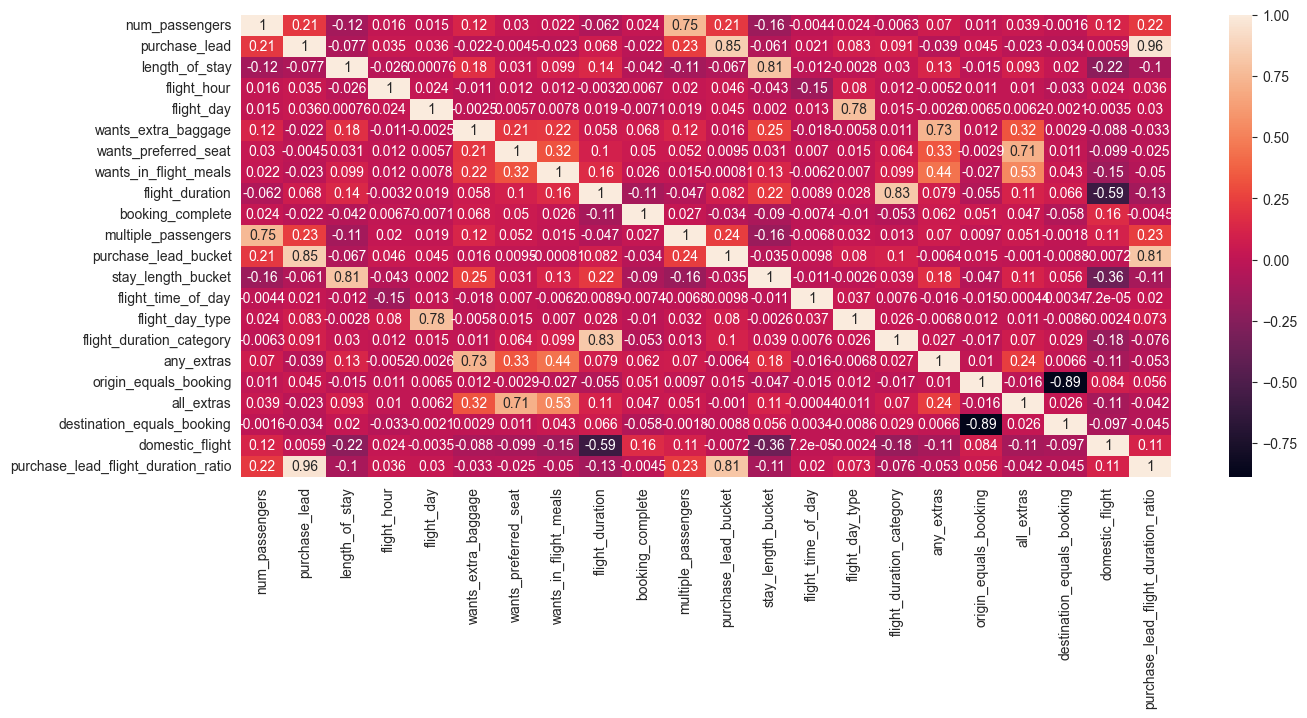

In [35]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.select_dtypes(['int64', 'float64', 'category']).corr(), annot=True)

# Modelling

## catboost only 

In [257]:
df_copy = df.drop(['country_origin', 'length_of_stay', 'purchase_lead', 'flight_duration', 'flight_hour', 'flight_day', 
                   'booking_origin', 'flight_day_type', 'multiple_passengers', 'flight_duration_category', 'any_extras', 'all_extras', 'trip_type', 'flight_time_of_day', 'origin_equals_booking'], axis=1)

In [205]:
df_copy = df[[  'num_passengers', 'sales_channel', 'trip_type', 'purchase_lead_bucket', 'stay_length_bucket', 'flight_hour_bucket', 'route', 'wants_extra_baggage', 'wants_preferred_seat',
'wants_in_flight_meals', 'flight_duration', 'any_extras',
  'country_origin', 'country_destination', 'flight_relation', 'all_extras', 'domestic_flight', 'purchase_lead_flight_duration_ratio',
 'purchase_lead_flight_num_pass', 'purchase_lead_flight_stay_length','flight_day', 'booking_complete']]

In [ ]:
['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead_bucket', 'stay_length_bucket', 'flight_hour_bucket', 'route', 'wants_extra_baggage', 'wants_preferred_seat',
'wants_in_flight_meals', 'flight_duration', 'multiple_passengers','flight_day', 'flight_day_type', 'flight_duration_category', 'any_extras',
 'booking_origin_code', 'country_origin', 'country_destination', 'flight_relation', 'all_extras', 'domestic_flight', 'purchase_lead_flight_duration_ratio',
 'purchase_lead_flight_num_pass', 'purchase_lead_flight_stay_length', 'booking_complete']

In [148]:
df

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49276               2      Internet  RoundTrip             27               6   
49277               1      Internet  RoundTrip            111               6   
49278               1      Internet  RoundTrip             24               6   
49279               1      Internet  RoundTrip             15               6   
49280               1      Internet  RoundTrip             19               6   

       flight_hour  flight_day   route booking_origin  wants_extra_baggage  \
0                7           6  AKLDEL    New Zealand                    1   
1                3           6  AKLDEL    New Zealand                    0   
2               17           3  AKLDEL          India                    1   
3                4           6  AKLDEL    New Zealand                    0   
4               15           3  AKLDEL          India                    1   
...            ...         ...     ...            ...                  ...   
49276            9           6  PERPNH      Australia                    1   
49277            4           7  PERPNH      Australia                    0   
49278           22           6  PERPNH      Australia                    0   
49279           11           1  PERPNH      Australia                    1   
49280           10           4  PERPNH      Australia                    0   

       ...  country_origin  zone_destination  country_destination  \
0      ...              NZ              Asia                   IN   
1      ...              NZ              Asia                   IN   
2      ...              NZ              Asia                   IN   
3      ...              NZ              Asia                   IN   
4      ...              NZ              Asia                   IN   
...    ...             ...               ...                  ...   
49276  ...              AU              Asia                   KH   
49277  ...              AU              Asia                   KH   
49278  ...              AU              Asia                   KH   
49279  ...              AU              Asia                   KH   
49280  ...              AU              Asia                   KH   

       booking_origin_code  origin_equals_booking flight_relation all_extras  \
0                       NZ                      1            from          0   
1                       NZ                      1            from          0   
2                       IN                      0              to          0   
3                       NZ                      1            from          0   
4                       IN                      0              to          0   
...                    ...                    ...             ...        ...   
49276                   AU                      1            from          0   
49277                   AU                      1            from          0   
49278                   AU                      1            from          0   
49279                   AU                      1            from          0   
49280                   AU                      1            from          0   

       destination_equals_booking  domestic_flight  \
0                               0                0   
1                               0                0   
2                               1                0   
3                               0                0   
4                               1    

In [152]:
df['trip_type'].value_counts()

trip_type
RoundTrip     48779
OneWay          386
CircleTrip      116
Name: count, dtype: int64

In [156]:
df[df['booking_complete'] == 1]['sales_channel'].value_counts()

sales_channel
Internet    6802
Mobile       589
Name: count, dtype: int64

In [137]:
df_copy

num_passengers sales_channel   route  wants_extra_baggage  \
0                   2      Internet  AKLDEL                    1   
1                   1      Internet  AKLDEL                    0   
2                   2      Internet  AKLDEL                    1   
3                   1      Internet  AKLDEL                    0   
4                   2      Internet  AKLDEL                    1   
...               ...           ...     ...                  ...   
49276               2      Internet  PERPNH                    1   
49277               1      Internet  PERPNH                    0   
49278               1      Internet  PERPNH                    0   
49279               1      Internet  PERPNH                    1   
49280               1      Internet  PERPNH                    0   

       wants_preferred_seat  wants_in_flight_meals  booking_complete  \
0                         0                      0                 0   
1                         0                      0                 0   
2                         1                      0                 0   
3                         0                      1                 0   
4                         0                      1                 0   
...                     ...                    ...               ...   
49276                     0                      1                 0   
49277                     0                      0                 0   
49278                     0                      1                 0   
49279                     0                      1                 0   
49280                     1                      0                 0   

      purchase_lead_bucket stay_length_bucket flight_origin  \
0                        5                  2           AKL   
1                        4                  2           AKL   
2                        5                  3           AKL   
3                        4                  3           AKL   
4                        4                  3           AKL   
...                    ...                ...           ...   
49276                    3                  1           PER   
49277                    4                  1           PER   
49278                    3                  1           PER   
49279                    2                  1           PER   
49280                    2                  1           PER   

      flight_destination zone_origin zone_destination country_destination  \
0                    DEL     Pacific             Asia                  IN   
1                    DEL     Pacific             Asia                  IN   
2                    DEL     Pacific             Asia                  IN   
3                    DEL     Pacific             Asia                  IN   
4                    DEL     Pacific             Asia                  IN   
...                  ...         ...              ...                 ...   
49276                PNH   Australia             Asia                  KH   
49277                PNH   Australia             Asia                  KH   
49278                PNH   Australia             Asia                  KH   
49279                PNH   Australia             Asia                  KH   
49280                PNH   Australia             Asia                  KH   

       origin_equals_booking flight_relation  destination_equals_booking  \
0                          1            from                           0   
1                          1            from                           0   
2                          0              to                           1   
3                          1            from                           0   
4                          0              to                           1   
...                      ...             ...                         ...   
49276                      1            from                           0   
49277                      1       

In [258]:
cat_cols = df_copy.select_dtypes(['object', 'category']).columns.tolist()

In [259]:
num_cols = [col for col in df_copy.columns if col not in cat_cols]

In [260]:
model = CatBoostClassifier()

In [261]:
X_train, X_test, y_train, y_test = train_test_split(df_copy.drop('booking_complete', axis=1), df_copy['booking_complete'], test_size=0.2,
                                                    stratify=df_copy['booking_complete'], random_state=42)

In [262]:
model.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_test, y_test), use_best_model=None)

Learning rate set to 0.078535
0:	learn: 0.6382575	test: 0.6384537	best: 0.6384537 (0)	total: 84.8ms	remaining: 1m 24s
1:	learn: 0.5885055	test: 0.5879570	best: 0.5879570 (1)	total: 118ms	remaining: 58.9s
2:	learn: 0.5508718	test: 0.5511496	best: 0.5511496 (2)	total: 189ms	remaining: 1m 2s
3:	learn: 0.5206072	test: 0.5207333	best: 0.5207333 (3)	total: 203ms	remaining: 50.6s
4:	learn: 0.4946191	test: 0.4946625	best: 0.4946625 (4)	total: 221ms	remaining: 44s
5:	learn: 0.4747298	test: 0.4759192	best: 0.4759192 (5)	total: 231ms	remaining: 38.2s
6:	learn: 0.4565795	test: 0.4577942	best: 0.4577942 (6)	total: 256ms	remaining: 36.4s
7:	learn: 0.4451309	test: 0.4461810	best: 0.4461810 (7)	total: 266ms	remaining: 33s
8:	learn: 0.4319148	test: 0.4338437	best: 0.4338437 (8)	total: 290ms	remaining: 32s
9:	learn: 0.4235546	test: 0.4251811	best: 0.4251811 (9)	total: 303ms	remaining: 30s
10:	learn: 0.4163701	test: 0.4177517	best: 0.4177517 (10)	total: 309ms	remaining: 27.8s
11:	learn: 0.4089459	test: 0

## Multiple models 

In [68]:
# df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
# df.head()
# df.drop_duplicates(inplace=True)

In [47]:
df_copy = df.drop(['country_origin', 'length_of_stay', 'purchase_lead', 'flight_duration', 'flight_hour', 'flight_day', 
                   'booking_origin', 'flight_day_type', 'multiple_passengers', 'flight_duration_category', 'any_extras', 'all_extras', 'trip_type', 'origin_equals_booking'], axis=1)

In [100]:
cat_cols = df.select_dtypes(['object', 'category']).columns.tolist()

In [279]:
cat_cols

['sales_channel',
 'route',
 'purchase_lead_bucket',
 'stay_length_bucket',
 'flight_origin',
 'flight_destination',
 'zone_origin',
 'zone_destination',
 'country_destination',
 'booking_origin_code',
 'flight_relation']

In [101]:
num_cols = [col for col in df.columns if col not in cat_cols and col != 'booking_complete']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('booking_complete', axis=1), df['booking_complete'], test_size=0.2,
                                                    stratify=df['booking_complete'], random_state=42)

In [103]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)  # OneHotEncode categorical columns
    ]
)

# Preprocess X_train first (before SMOTE)
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [104]:
log_model = LogisticRegression(class_weight='balanced', max_iter=1000)

In [105]:
log_model.fit(X_train_preprocessed, y_train)

# Preprocess the test set using the same preprocessor
X_test_preprocessed = preprocessor.transform(X_test) 

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)  # OneHotEncode categorical columns
    ]
)

# Preprocess X_train first (before SMOTE)
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Apply SMOTE to balance the preprocessed training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# List of classifiers to evaluate
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    # 'Support Vector Classifier': SVC(class_weight='balanced', probability=True),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    # 'Naive Bayes': GaussianNB(),
    'CatBoost Classifier': CatBoostClassifier()
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    # Create a pipeline with the model (preprocessing has already been applied before SMOTE)
    pipeline = Pipeline(steps=[('classifier', model)])
    
    # Fit the model using cross-validation and get cross-validation scores
    # cv_scores = cross_val_score(pipeline, X_train_preprocessed, y_train, cv=5, scoring='roc_auc')
    
    # Fit the pipeline on the full resampled training set
    pipeline.fit(X_train_preprocessed, y_train)
    
    # Preprocess the test set using the same preprocessor
    X_test_preprocessed = preprocessor.transform(X_test)  # Use transform, not fit_transform!
    
    # Generate predictions on the test set
    y_pred = pipeline.predict(X_test_preprocessed)
    y_pred_proba = pipeline.predict_proba(X_test_preprocessed)[:, 1]
    
    # Calculate evaluation metrics
    results[model_name] = {
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'roc_auc_score': roc_auc_score(y_test, y_pred_proba),
        # 'cross_val_mean_score': np.mean(cv_scores),
        # 'cross_val_std_score': np.std(cv_scores)
    }
    
    print(f'{model_name} finished')

# Display the results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    # print("Cross-Validation Mean ROC AUC Score:", metrics['cross_val_mean_score'])
    # print("Cross-Validation Standard Deviation:", metrics['cross_val_std_score'])
    print("Confusion Matrix:\n", metrics['confusion_matrix'])
    print("Classification Report:\n", print(metrics['classification_report']))
    print("ROC AUC Score:", metrics['roc_auc_score'])
    print("\n" + "-"*50 + "\n")

Learning rate set to 0.049468
0:	learn: 0.6602786	total: 12.1ms	remaining: 12.1s
1:	learn: 0.6275486	total: 21.9ms	remaining: 10.9s
2:	learn: 0.6021695	total: 31ms	remaining: 10.3s
3:	learn: 0.5771006	total: 40ms	remaining: 9.95s
4:	learn: 0.5555993	total: 49.3ms	remaining: 9.82s
5:	learn: 0.5378888	total: 58.7ms	remaining: 9.73s
6:	learn: 0.5206125	total: 70.7ms	remaining: 10s
7:	learn: 0.5058886	total: 80ms	remaining: 9.93s
8:	learn: 0.4932723	total: 90.9ms	remaining: 10s
9:	learn: 0.4800698	total: 108ms	remaining: 10.7s
10:	learn: 0.4692524	total: 117ms	remaining: 10.5s
11:	learn: 0.4597482	total: 127ms	remaining: 10.4s
12:	learn: 0.4526501	total: 137ms	remaining: 10.4s
13:	learn: 0.4436336	total: 157ms	remaining: 11.1s
14:	learn: 0.4363106	total: 173ms	remaining: 11.3s
15:	learn: 0.4316480	total: 178ms	remaining: 10.9s
16:	learn: 0.4270693	total: 184ms	remaining: 10.7s
17:	learn: 0.4225085	total: 191ms	remaining: 10.4s
18:	learn: 0.4186949	total: 197ms	remaining: 10.2s
19:	learn: 0

In [27]:
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    # print("Cross-Validation Mean ROC AUC Score:", metrics['cross_val_mean_score'])
    # print("Cross-Validation Standard Deviation:", metrics['cross_val_std_score'])
    print("Confusion Matrix:\n", metrics['confusion_matrix'])
    print("Classification Report:\n", metrics['classification_report'])`
    print("ROC AUC Score:", metrics['roc_auc_score'])
    print("\n" + "-"*50 + "\n")

Model: Logistic Regression
Confusion Matrix:
 [[5799 2580]
 [ 388 1090]]
Classification Report:
 {'0': {'precision': 0.9372878616453855, 'recall': 0.6920873612602936, 'f1-score': 0.7962378140876013, 'support': 8379.0}, '1': {'precision': 0.2970027247956403, 'recall': 0.7374830852503383, 'f1-score': 0.4234654234654235, 'support': 1478.0}, 'accuracy': 0.6988941868722736, 'macro avg': {'precision': 0.6171452932205129, 'recall': 0.714785223255316, 'f1-score': 0.6098516187765124, 'support': 9857.0}, 'weighted avg': {'precision': 0.8412808176904375, 'recall': 0.6988941868722736, 'f1-score': 0.7403427554146198, 'support': 9857.0}}
ROC AUC Score: 0.772736823048665

--------------------------------------------------

Model: Random Forest
Confusion Matrix:
 [[6723 1656]
 [ 708  770]]
Classification Report:
 {'0': {'precision': 0.9047234557932984, 'recall': 0.8023630504833512, 'f1-score': 0.8504743833017078, 'support': 8379.0}, '1': {'precision': 0.3173948887056884, 'recall': 0.5209742895805142, 

# Evaluation

In [1]:
y_pred = model.predict(X_test)

NameError: name 'model' is not defined

In [54]:
y_pred_log = pipeline.predict(X_test_preprocessed)

In [106]:
y_pred_log_2 = log_model.predict(X_test_preprocessed)

In [107]:
print(classification_report(y_test, y_pred_log_2))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      8379
           1       0.30      0.74      0.42      1478

    accuracy                           0.70      9857
   macro avg       0.62      0.72      0.61      9857
weighted avg       0.84      0.70      0.74      9857



In [77]:
print(classification_report(y_test, y_pred_log_2))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      8379
           1       0.30      0.74      0.42      1478

    accuracy                           0.70      9857
   macro avg       0.62      0.71      0.61      9857
weighted avg       0.84      0.70      0.74      9857



In [55]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      8379
           1       0.30      0.74      0.42      1478

    accuracy                           0.70      9857
   macro avg       0.62      0.71      0.61      9857
weighted avg       0.84      0.70      0.74      9857



Text(0.5, 1.0, 'Confusion Matrix')

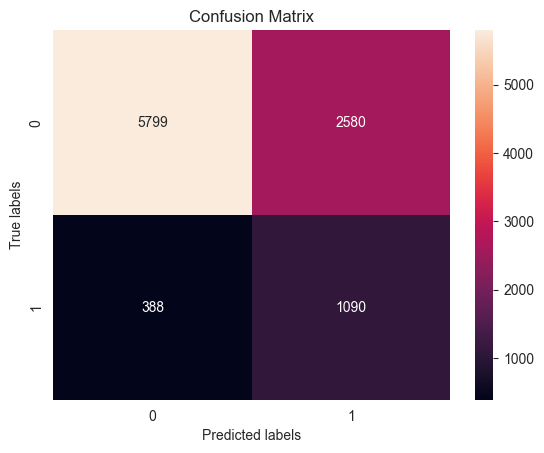

In [108]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True,fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

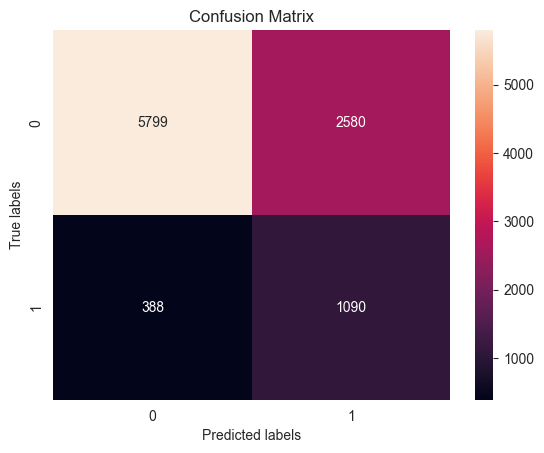

In [56]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True,fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_log)
roc_auc = auc(fpr, tpr)

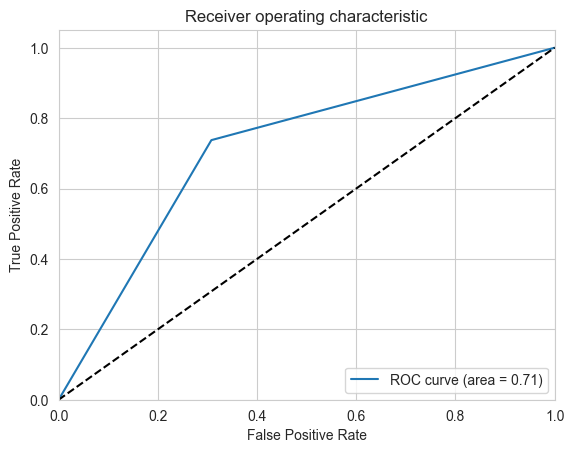

In [110]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [111]:
feature_importance = log_model.coef_[0]

# 1. Get the feature names from OneHotEncoder for categorical features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

# 2. Initialize dictionary to store importance for original features
original_feature_importance = {}

# Add numerical columns directly to feature importance (if any)
for col in num_cols:
    original_feature_importance[col] = 0  # No numerical columns in this example, modify if needed

# 3. Map coefficients back to original categorical features by summing over each category
for i, col in enumerate(cat_cols):
    # Get indices of all one-hot encoded columns for this categorical feature
    related_columns = [name for name in cat_feature_names if name.startswith(col)]
    
    # Find the indices of the related columns in the full feature set
    related_indices = [list(cat_feature_names).index(name) for name in related_columns]
    
    # Sum the absolute values of the coefficients for these one-hot encoded columns
    original_feature_importance[col] = np.sum(np.abs(feature_importance[related_indices]))

# 4. Create a DataFrame to display original feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': list(original_feature_importance.keys()),
    'Importance': list(original_feature_importance.values())
})

# Sort by absolute importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importance
print(feature_importance_df)

                                Feature  Importance
21                                route  382.121540
22                       booking_origin   72.046603
32                  booking_origin_code   36.132183
26                        flight_origin   32.850530
27                   flight_destination   22.861007
29                       country_origin   10.891022
31                  country_destination    7.495596
24                   stay_length_bucket    1.278162
23                 purchase_lead_bucket    1.248123
20                            trip_type    0.911457
28                          zone_origin    0.800920
19                        sales_channel    0.744908
33                      flight_relation    0.255742
25             flight_duration_category    0.016455
30                     zone_destination    0.015387
1                         purchase_lead    0.000000
18        purchase_lead_flight_num_pass    0.000000
0                        num_passengers    0.000000
16          

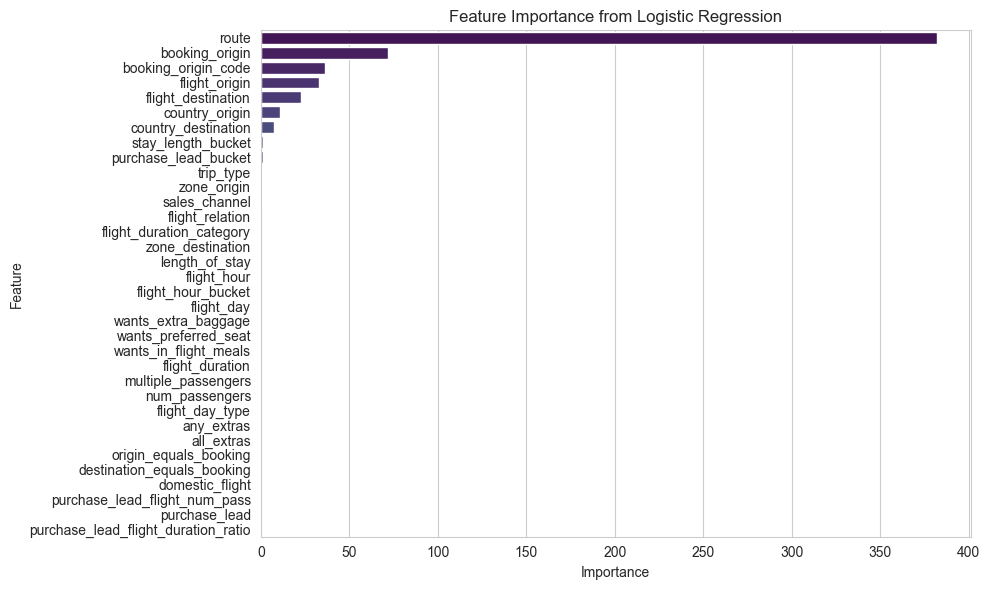

In [112]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

plt.title('Feature Importance from Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Show the plot
plt.tight_layout()
plt.show()

In [119]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      8379
           1       0.47      0.10      0.16      1478

    accuracy                           0.85      9857
   macro avg       0.67      0.54      0.54      9857
weighted avg       0.80      0.85      0.80      9857



Text(0.5, 1.0, 'Confusion Matrix')

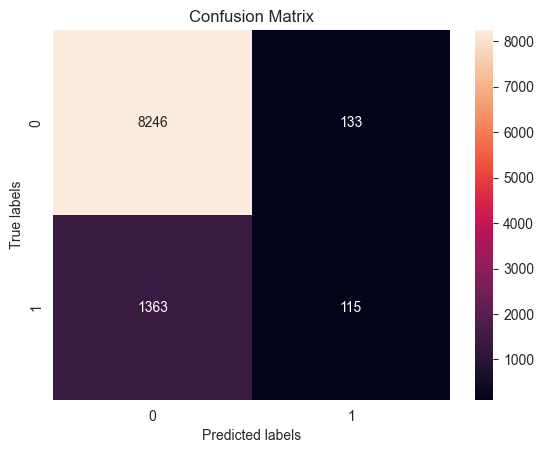

In [265]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

In [52]:
evaluation_pd = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred), 'recall': recall_score(y_test, y_pred), 
              'precision': precision_score(y_test, y_pred), 'f1': f1_score(y_test, y_pred), 'roc_auc': roc_auc}, index=[0])

In [53]:
evaluation_pd

accuracy    recall  precision        f1   roc_auc
0  0.847824  0.094046   0.463333  0.156355  0.537416

In [244]:
evaluation_pd.append({'accuracy': accuracy_score(y_test, y_pred), 'recall': recall_score(y_test, y_pred), 
              'precision': precision_score(y_test, y_pred), 'f1': f1_score(y_test, y_pred), 'roc_auc': roc_auc}, ignore_index=True)

accuracy    recall  precision        f1   roc_auc
0  0.849853  0.084574   0.496032  0.144509  0.534708

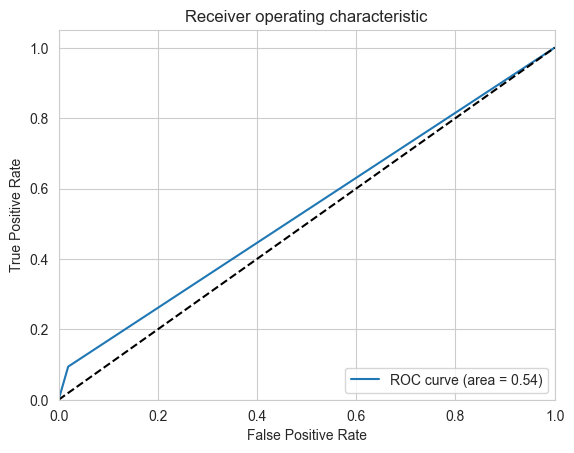

In [253]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [266]:
feature_importance = model.get_feature_importance()
feature_names = model.feature_names_

Text(0, 0.5, 'Feature name')

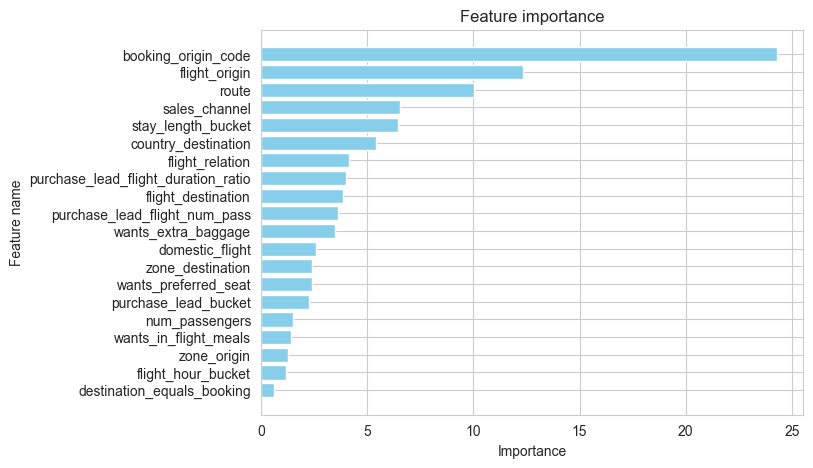

In [267]:
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
plt.figure(figsize=(7,5))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.title('Feature importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis() 
plt.ylabel('Feature name')

Text(0, 0.5, 'Feature name')

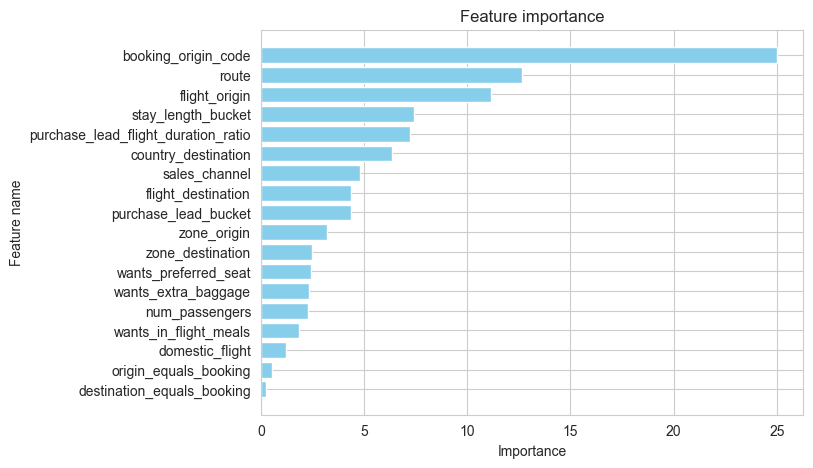

In [123]:
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
plt.figure(figsize=(7,5))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.title('Feature importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis() 
plt.ylabel('Feature name')

In [ ]:
'origin_equals_booking', 'destination_equals_booking'

In [94]:
df_copy

num_passengers sales_channel  trip_type   route  wants_extra_baggage  \
0                   2      Internet  RoundTrip  AKLDEL                    1   
1                   1      Internet  RoundTrip  AKLDEL                    0   
2                   2      Internet  RoundTrip  AKLDEL                    1   
3                   1      Internet  RoundTrip  AKLDEL                    0   
4                   2      Internet  RoundTrip  AKLDEL                    1   
...               ...           ...        ...     ...                  ...   
49276               2      Internet  RoundTrip  PERPNH                    1   
49277               1      Internet  RoundTrip  PERPNH                    0   
49278               1      Internet  RoundTrip  PERPNH                    0   
49279               1      Internet  RoundTrip  PERPNH                    1   
49280               1      Internet  RoundTrip  PERPNH                    0   

       wants_preferred_seat  wants_in_flight_meals  booking_complete  \
0                         0                      0                 0   
1                         0                      0                 0   
2                         1                      0                 0   
3                         0                      1                 0   
4                         0                      1                 0   
...                     ...                    ...               ...   
49276                     0                      1                 0   
49277                     0                      0                 0   
49278                     0                      1                 0   
49279                     0                      1                 0   
49280                     1                      0                 0   

       multiple_passengers purchase_lead_bucket  ... zone_origin  \
0                        1                    5  ...     Pacific   
1                        0                    4  ...     Pacific   
2                        1                    5  ...     Pacific   
3                        0                    4  ...     Pacific   
4                        1                    4  ...     Pacific   
...                    ...                  ...  ...         ...   
49276                    1                    3  ...   Australia   
49277                    0                    4  ...   Australia   
49278                    0                    3  ...   Australia   
49279                    0                    2  ...   Australia   
49280                    0                    2  ...   Australia   

       zone_destination  country_destination booking_origin_code  \
0                  Asia                   IN                  NZ   
1                  Asia                   IN                  NZ   
2                  Asia                   IN                  IN   
3                  Asia                   IN                  NZ   
4                  Asia                   IN                  IN   
...                 ...                  ...                 ...   
49276              Asia                   KH                  AU   
49277              Asia                   KH                  AU   
49278              Asia                   KH                  AU   
49279              Asia                   KH                  AU   
49280              Asia                   KH                  AU   

       origin_equals_booking flight_relation all_extras  \
0                          1            from          0   
1                          1            from          0   
2                          0              to          0   
3                          1            from          0   
4                          0              to          0   
...                      ...             ...        ...   
49276                      1            from          0   
49277                      1            from          0   
49278                      1

In [109]:
df[['booking_origin', 'country_origin', 'flight_origin', 'booking_origin_code', 'flight_destination']]

booking_origin country_origin flight_origin booking_origin_code  \
0        New Zealand             NZ           AKL                  NZ   
1        New Zealand             NZ           AKL                  NZ   
2              India             NZ           AKL                  IN   
3        New Zealand             NZ           AKL                  NZ   
4              India             NZ           AKL                  IN   
...              ...            ...           ...                 ...   
49276      Australia             AU           PER                  AU   
49277      Australia             AU           PER                  AU   
49278      Australia             AU           PER                  AU   
49279      Australia             AU           PER                  AU   
49280      Australia             AU           PER                  AU   

      flight_destination  
0                    DEL  
1                    DEL  
2                    DEL  
3                    DEL  
4                    DEL  
...                  ...  
49276                PNH  
49277                PNH  
49278                PNH  
49279                PNH  
49280                PNH  

[49281 rows x 5 columns]

In [62]:
df.groupby('country_origin')['flight_origin'].nunique()

country_origin
AU     4
BD     1
BN     1
CN     8
HK     1
ID    10
IN    10
IR     1
JP     4
KH     3
KR     2
LA     1
LK     1
MM     1
MO     1
MU     1
MV     1
MY    14
NP     1
NZ     1
PH     4
SA     1
SG     1
TH     6
TW     2
VN     4
Name: flight_origin, dtype: int64

TODO:
- add more analysis, especially for categorical features
- do feature engineering 
- add feature selection
- deal with imbalance
- add cross_validation
- add more models and evaluate all of them 
- add voting system 
- make presentation
- 3D models with features